# Brain storming ideas to orchestrate new featurse and try them in practice

## Some ideas to try:
1. GuestRooms/Rooms: GuestRooms to Rooms ratio 
2. Rooms/Floors: Number of rooms per floor
3. Attic/squareMeters:  Attic size to total house size ratio
4. Basement/squareMeters: Basement size to total house size ratio
5. Garage/squareMeters: Garage size to total house size ratio
6. Group zip codes by like all starting with 35 in one bucket etc and add a avgCost per house in the area feature. maybe create buckets like 0-100, 100-200, 200-300 etc

In [1]:
# !pip install mplcyberpunk

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import mplcyberpunk

import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from sklearn.preprocessing import StandardScaler

import copy

In [4]:
from warnings import filterwarnings
filterwarnings("ignore")
# plt.style.use("cyberpunk")

# Loading Data

In [49]:
# setting a base path variable for easy access
BASE_PATH = Path("/kaggle/input/playground-series-s3e6")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns=["id"])

test = pd.read_csv(BASE_PATH / "test.csv")
# we need the test id column to make the submission
test_idx = test.id
test = test.drop(columns=["id"])

# we also load original dataset and will try to gauge if adding it to the competition datasets boosts our score or not
original = pd.read_csv("/kaggle/input/paris-housing-price-prediction/ParisHousing.csv")

### Features Presence Check
Checkingg if the competition dataset and original dataset contain the same features in same order, so we can concatenate them easily. Otherwise we'll have to manually make them consistent

In [6]:
all(original.columns == train.columns)

True

#### Result:
Well both dataset indeed contain the same features in the same order. No need for any manual work!

In [50]:
all_datasets = {"train": train, "test": test,"original": original}

# Analyzing Data
Here I won't go in detail about the features distribution similarities and contrasts between the competition and original datasets because that would make this notebook quite complicated for newcomers to this platform and field.

I'll most probably make a separate notebook for this comparison b/w competition and original dataset.

## Checking for missing values

In [8]:
pd.concat([dataset.isnull().sum().rename(f"Missing in {dataset_name}") 
               for dataset_name, dataset in all_datasets.items()],
                 axis=1)

,Missing in train,Missing in test,Missing in original
squareMeters,0,0.0,0
numberOfRooms,0,0.0,0
hasYard,0,0.0,0
hasPool,0,0.0,0
floors,0,0.0,0
cityCode,0,0.0,0
cityPartRange,0,0.0,0
numPrevOwners,0,0.0,0
made,0,0.0,0
isNewBuilt,0,0.0,0


### INSIGHTS:
We're in luck, none of the datasets contain any missing value.

Also test dataframe has **NaN** for price because it doesn't contain price i.e. target feature.

# Preprocess

In [9]:
def preprocess(datasets:dict, target:str):
    """Preprocess the data
        datasets: Expects a dict with datasets name as keys and datasets as values
            Valid names for dataets are: [train, test, original]
        
        target: name of the target column
    """
    for dataset_name, dataset in datasets.items():
        if dataset_name == "train":
            y = train[target]
            X = train.drop(columns=[target])
        elif dataset_name == "original":
            y_org = original[target]
            X_org = original.drop(columns=[target])
        elif dataset_name == "test":
            X_test = test.copy()
        
        
    X_combined = pd.concat([X, X_org], axis=0)
    y_combined = pd.concat([y, y_org], axis=0)

    return {"train": {"data": X, "target": y}, "original": {"data": X_org,  "target": y_org},
            "combined": {"data": X_combined, "target": y_combined}, "test": {"data": X_test}}    

In [10]:
processed_datasets = preprocess(all_datasets, "price")

X, y = processed_datasets["train"].values()
X_org, y_org = processed_datasets["original"].values()
X_combined, y_combined = processed_datasets["combined"].values()
X_test = processed_datasets["test"].values()

# Cross Validate

In [11]:
def cross_validate(X, y, X_org, y_org, model, model_verbose):
    N_FOLDS = 8
    cv_scores = np.zeros(N_FOLDS)
    feature_importances_all_folds = np.zeros(shape=(N_FOLDS, len(X.columns)))
    feature_names = X.columns
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # As has been shown in the previous competitions that
        # train on the combined(competition + original) dataset
        # but evaluate only on competition dataset
        
        X_train = pd.concat([X_train, X_org], axis=0)
        y_train = pd.concat([y_train, y_org], axis=0)
        
        if model=="XGBoost":
            model = xgb.XGBRegressor(eval_metric="rmse")
        elif model=="LightGBM":
            model = lgbm.LGBMRegressor()
        elif model=="CatBoost":
            model = catboost.CatBoostRegressor(eval_metric="RMSE")
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                 verbose=model_verbose)
        
        y_preds = model.predict(X_val)
        
        # to calculate rmse instead of mse, we set squared=False
        rmse = mean_squared_error(y_val, y_preds, squared=False)
        cv_scores[fold_num] = rmse        
        print(f"Fold {fold_num} \t RMSE: {rmse}")
        
        # we'll average feature importances across all folds and plot the averaged values
        feature_importances_all_folds[fold_num] = model.feature_importances_
        
    avg_rmse = np.mean(cv_scores)
    print(f"AVG RMSE: {avg_rmse}")
    
    avg_feature_importances = np.mean(feature_importances_all_folds, axis=0)
    
    plot_feature_importances(feature_names, avg_feature_importances)

# Plot Feature Importances

In [12]:
def plot_feature_importances(feature_names, feature_importances):
    fig = plt.figure(figsize = (15, 0.35*len(feature_importances)))
    feature_imp_df = pd.DataFrame(data=zip(feature_names, feature_importances), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)
    plt.title('Feature importances', size=25, y=1.05)
    sns.barplot(data=feature_imp_df, x='importance', y='feature')
    plt.show()

# Feature Engineering
## Some ideas to try:
1. GuestRooms/Rooms: GuestRooms to Rooms ratio 
2. Number of non guest rooms: NumOfRooms - GuestRooms
3. Rooms/Floors: Number of rooms per floor
4. Attic/squareMeters:  Attic size to total house size ratio
5. Basement/squareMeters: Basement size to total house size ratio
6. Garage/squareMeters: Garage size to total house size ratio
7. Group zip codes by like all starting with 35 in one bucket etc. maybe create buckets like 0-100, 100-200, 200-300 etc. This way some areas may emerge where land value is more expensive than others

In [13]:
def try_new_feature(X, y, X_org, y_org):    
    models = ["XGBoost", "LightGBM", "CatBoost"]
    
    for model in models:
        print(f"{'-'*20} {model} {'-'*20}")
        
        verbose = False
        if model=="LightGBM":
            verbose = -1
            
        cross_validate(X, y, X_org, y_org, model=model, model_verbose=verbose)

In [18]:
def test_it(all_datasts:dict):
    processed_datasets = preprocess(all_datasets, "price")
    X, y = processed_datasets["train"].values()
    X_org, y_org = processed_datasets["original"].values()
    X_combined, y_combined = processed_datasets["combined"].values()
    X_test = processed_datasets["test"].values()

    try_new_feature(X, y, X_org, y_org)

# Setting a baseline

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 154188.27278516119
Fold 1 	 RMSE: 127635.99800495614
Fold 2 	 RMSE: 66390.78593262316
Fold 3 	 RMSE: 168424.67336041204
Fold 4 	 RMSE: 73247.73085932412
Fold 5 	 RMSE: 284545.5162397819
Fold 6 	 RMSE: 177638.5351377841
Fold 7 	 RMSE: 63436.759232980054
AVG RMSE: 139438.53394412785


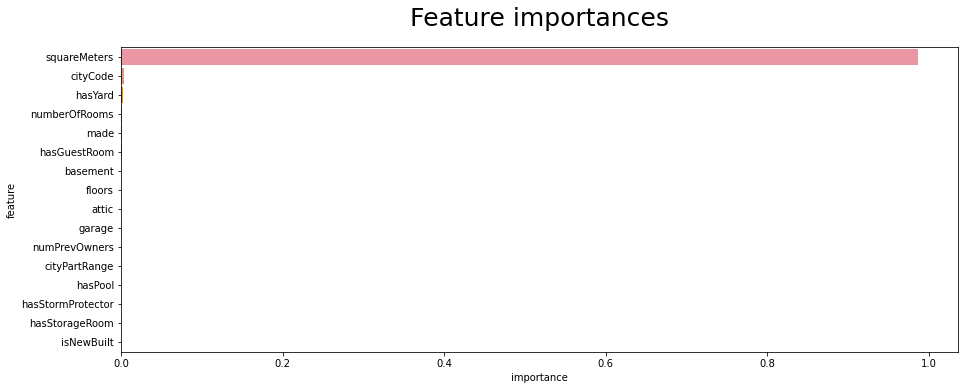

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171301.47035466178
Fold 1 	 RMSE: 155822.76775984338
Fold 2 	 RMSE: 56447.042274015235
Fold 3 	 RMSE: 202119.25533245484
Fold 4 	 RMSE: 61658.562946096485
Fold 5 	 RMSE: 285890.72441570566
Fold 6 	 RMSE: 209641.8411362364
Fold 7 	 RMSE: 88189.80989517206
AVG RMSE: 153883.9342642732


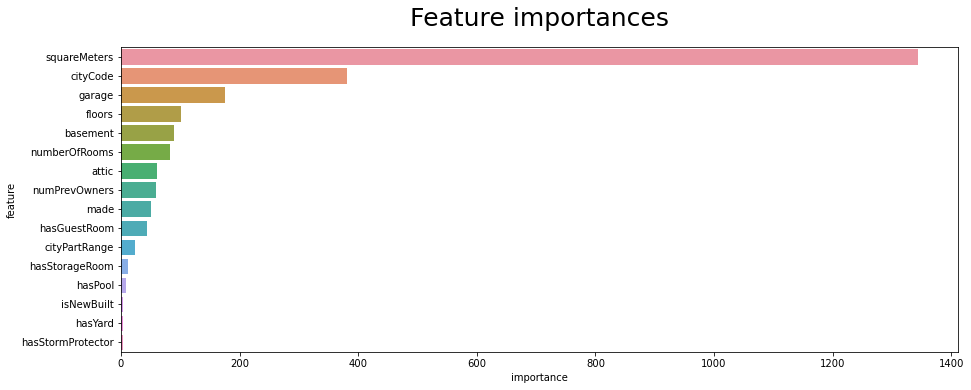

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 172993.82348787365
Fold 1 	 RMSE: 140587.4331313195
Fold 2 	 RMSE: 31505.182419820227
Fold 3 	 RMSE: 191522.92547325962
Fold 4 	 RMSE: 68043.19116808847
Fold 5 	 RMSE: 278396.3614567066
Fold 6 	 RMSE: 204413.8664501247
Fold 7 	 RMSE: 81685.70979335811
AVG RMSE: 146143.56167256885


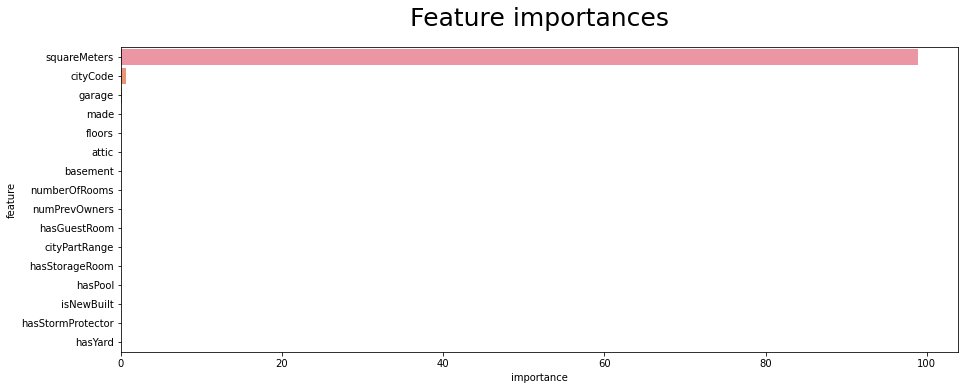

In [14]:
try_new_feature(X, y, X_org, y_org)

# FeatIdea #1: guestRooms/numberOfRooms

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 161360.63421436073
Fold 1 	 RMSE: 128101.89489158327
Fold 2 	 RMSE: 67560.00404284982
Fold 3 	 RMSE: 164609.895573848
Fold 4 	 RMSE: 74502.57369053243
Fold 5 	 RMSE: 284545.51565112994
Fold 6 	 RMSE: 178306.47941158863
Fold 7 	 RMSE: 62617.15573203836
AVG RMSE: 140200.5191509914


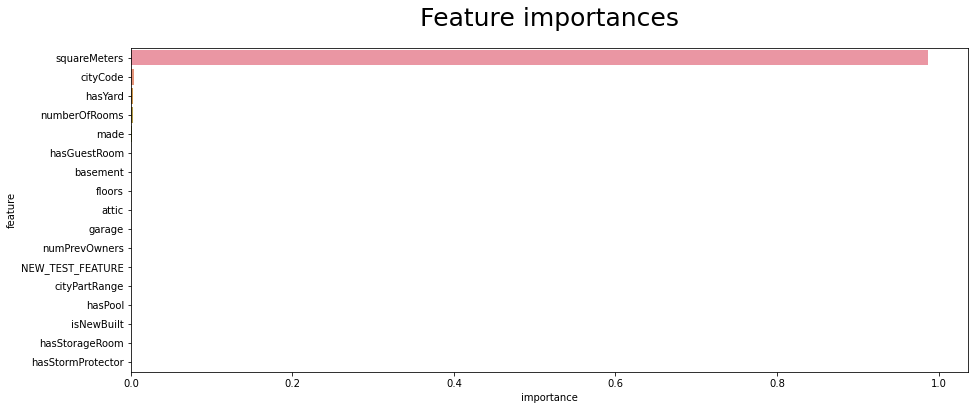

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171224.90444725347
Fold 1 	 RMSE: 153621.54348711637
Fold 2 	 RMSE: 56376.24570956191
Fold 3 	 RMSE: 201292.2712899977
Fold 4 	 RMSE: 61469.57527099367
Fold 5 	 RMSE: 285624.0334257795
Fold 6 	 RMSE: 209908.82741168886
Fold 7 	 RMSE: 88678.6073878769
AVG RMSE: 153524.50105378355


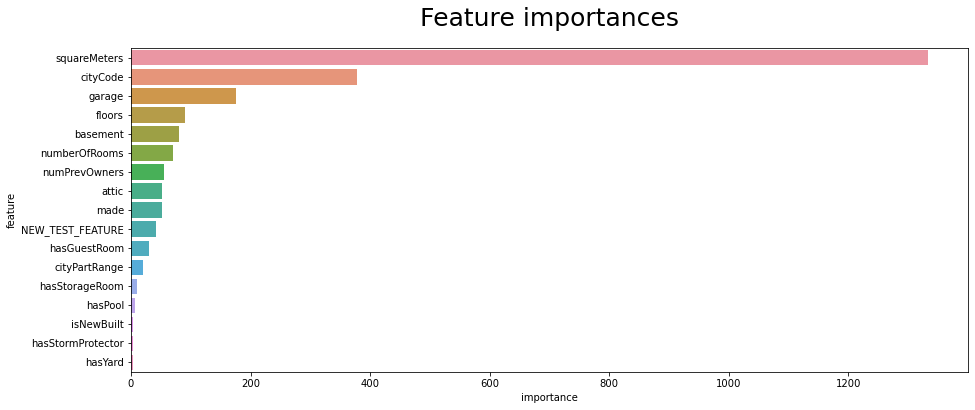

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 174135.09702092796
Fold 1 	 RMSE: 142958.81250773382
Fold 2 	 RMSE: 37428.821565545244
Fold 3 	 RMSE: 185073.66640351663
Fold 4 	 RMSE: 64589.89128050242
Fold 5 	 RMSE: 278567.8687675973
Fold 6 	 RMSE: 200908.17334696304
Fold 7 	 RMSE: 82933.03622831889
AVG RMSE: 145824.42089013816


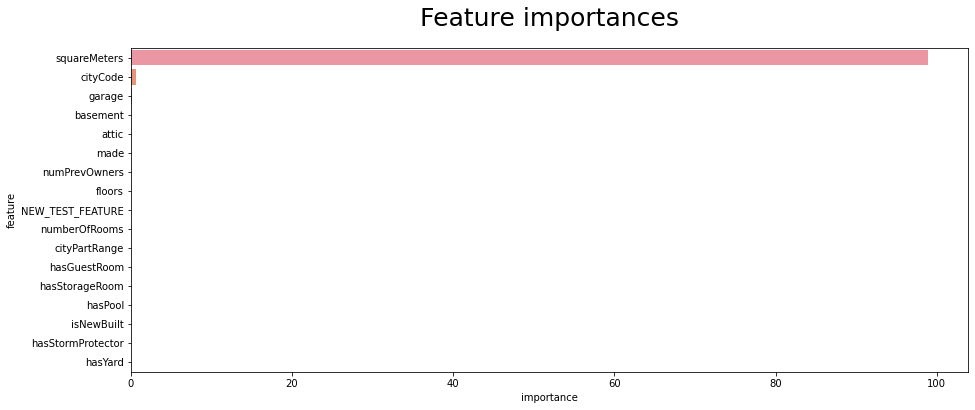

In [17]:
# featIdea #1
for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.hasGuestRoom / dataset.numberOfRooms

test_it(all_datasets)

## Result: No real difference.

# FeatIdea #2: Number of non guest rooms: NumOfRooms - GuestRooms

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 156714.69501660546
Fold 1 	 RMSE: 128070.19953880023
Fold 2 	 RMSE: 65559.72904734034
Fold 3 	 RMSE: 168486.58797863033
Fold 4 	 RMSE: 73558.67697287172
Fold 5 	 RMSE: 284544.99192377593
Fold 6 	 RMSE: 176381.72545998983
Fold 7 	 RMSE: 58970.10390513149
AVG RMSE: 139035.83873039315


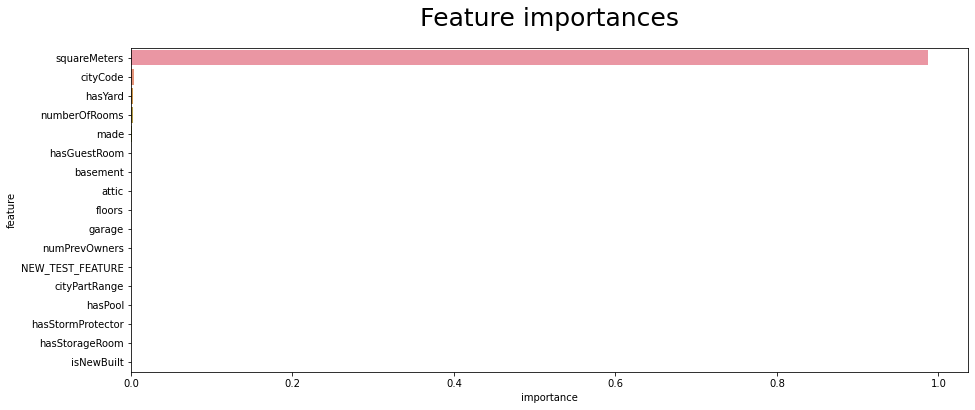

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171731.9216912249
Fold 1 	 RMSE: 155260.186637042
Fold 2 	 RMSE: 54962.89094322006
Fold 3 	 RMSE: 202632.85230137224
Fold 4 	 RMSE: 61442.026448391305
Fold 5 	 RMSE: 284660.7076160703
Fold 6 	 RMSE: 209348.52616711115
Fold 7 	 RMSE: 84052.24886975702
AVG RMSE: 153011.42008427362


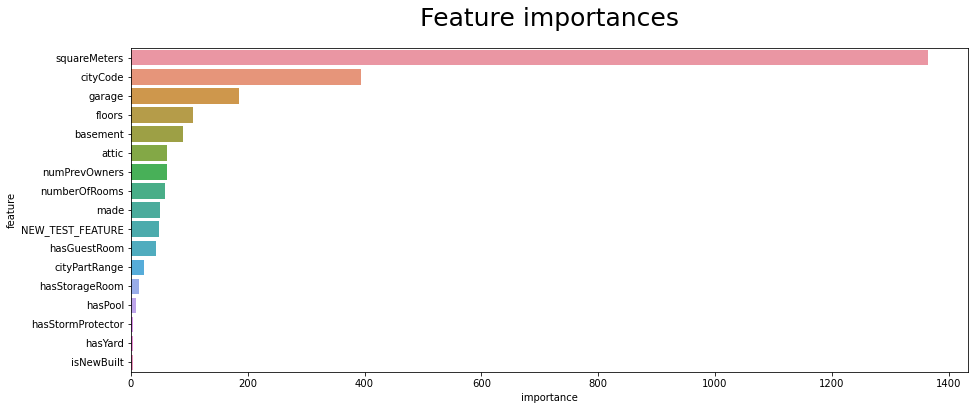

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 173604.6320198443
Fold 1 	 RMSE: 142847.99882856963
Fold 2 	 RMSE: 33974.75368606736
Fold 3 	 RMSE: 187261.2688748412
Fold 4 	 RMSE: 66090.2389374152
Fold 5 	 RMSE: 279302.1923306605
Fold 6 	 RMSE: 198306.4684717369
Fold 7 	 RMSE: 88476.88301733248
AVG RMSE: 146233.05452080845


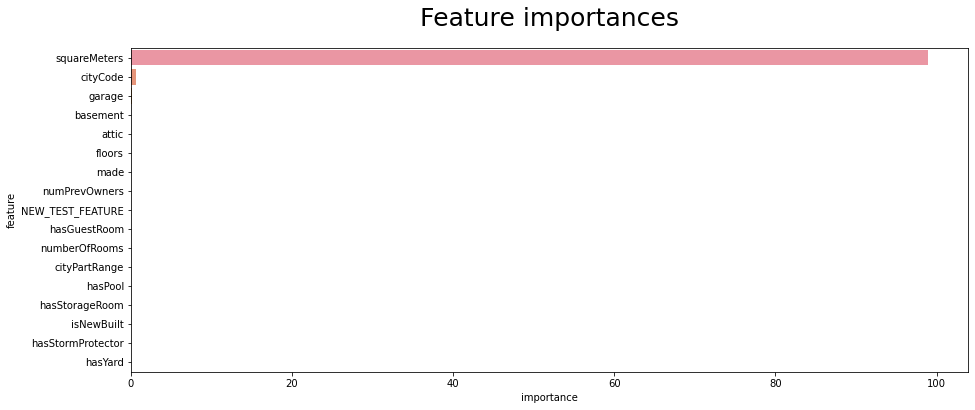

In [19]:
for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.numberOfRooms - dataset.hasGuestRoom

test_it(all_datasets)

## Result: Seems useful!

# FeatIdea #3: Rooms/Floors: Number of rooms per floor

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 153235.69170786557
Fold 1 	 RMSE: 127718.7851794453
Fold 2 	 RMSE: 68188.21698377482
Fold 3 	 RMSE: 163013.63490011182
Fold 4 	 RMSE: 77474.18483282406
Fold 5 	 RMSE: 284493.6112939831
Fold 6 	 RMSE: 181432.0552974596
Fold 7 	 RMSE: 67553.07980488463
AVG RMSE: 140388.6575000436


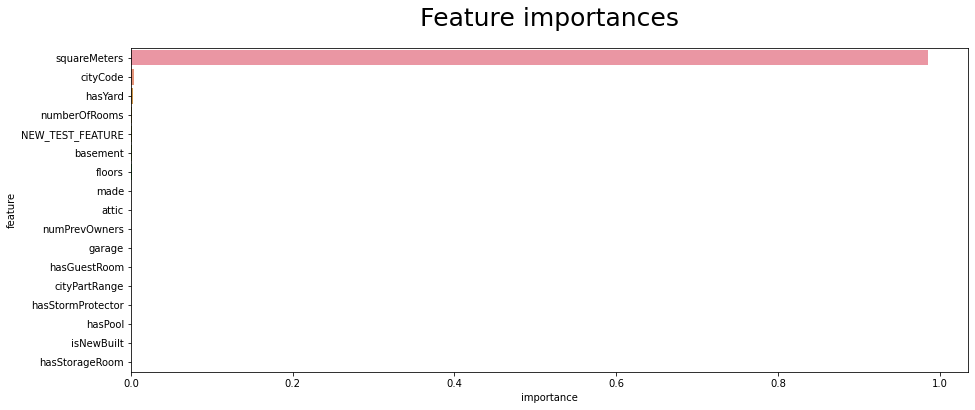

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171240.46964006088
Fold 1 	 RMSE: 152165.10982350906
Fold 2 	 RMSE: 60571.43325109991
Fold 3 	 RMSE: 199895.84956270826
Fold 4 	 RMSE: 61986.03312079665
Fold 5 	 RMSE: 285382.44395295833
Fold 6 	 RMSE: 210196.57073795772
Fold 7 	 RMSE: 88307.47042610955
AVG RMSE: 153718.17256440004


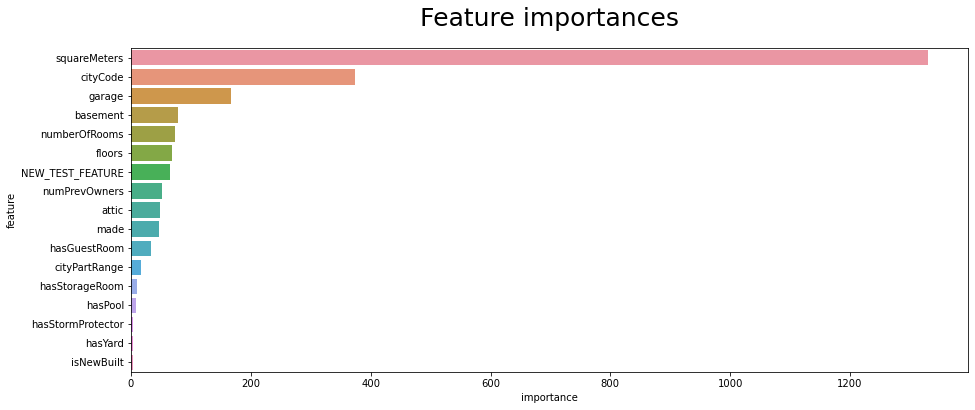

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 173100.48515204908
Fold 1 	 RMSE: 150458.9071858103
Fold 2 	 RMSE: 36230.84676818835
Fold 3 	 RMSE: 188978.94522245746
Fold 4 	 RMSE: 64355.08370216703
Fold 5 	 RMSE: 279032.00322634267
Fold 6 	 RMSE: 196763.3684681658
Fold 7 	 RMSE: 98398.72851073684
AVG RMSE: 148414.7960294897


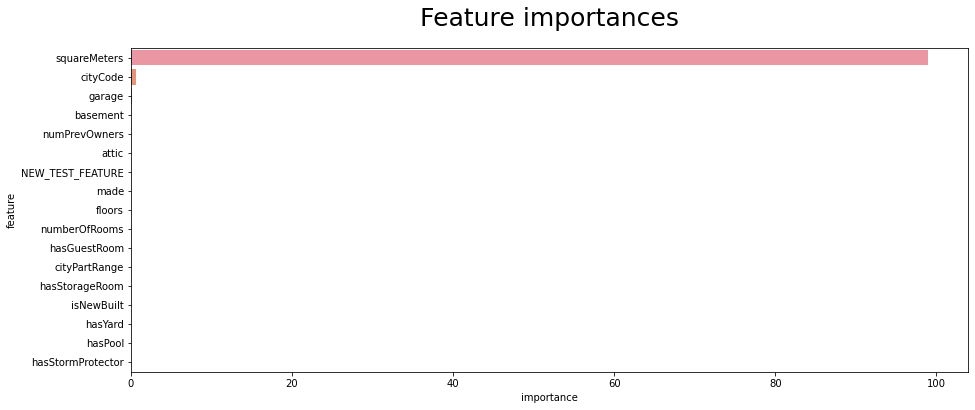

In [20]:
for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.numberOfRooms // dataset.floors

test_it(all_datasets)

## Result: Okay this feature seems important!

# FeatIdea #4: Attic/squareMeters:  Attic size to total house size ratio

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 153542.420669415
Fold 1 	 RMSE: 129005.7515727272
Fold 2 	 RMSE: 66963.82246839095
Fold 3 	 RMSE: 159907.42690238036
Fold 4 	 RMSE: 74346.5310837884
Fold 5 	 RMSE: 284623.74192912737
Fold 6 	 RMSE: 176638.5245533755
Fold 7 	 RMSE: 71098.095521099
AVG RMSE: 139515.78933753795


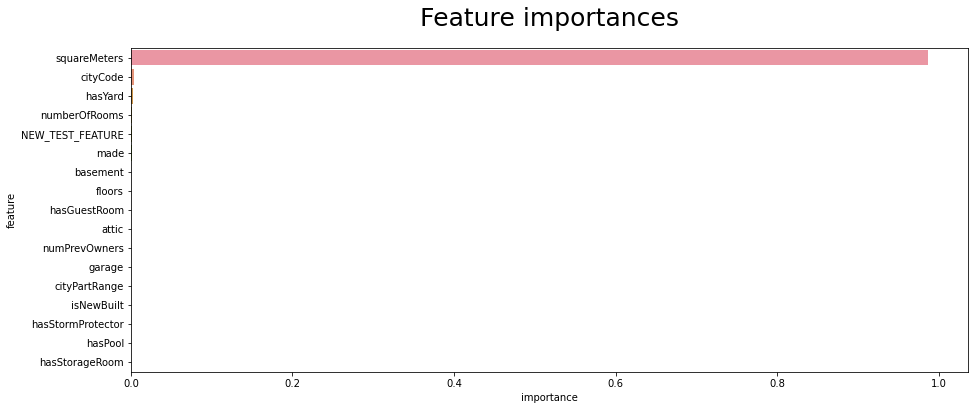

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171609.5203514674
Fold 1 	 RMSE: 153772.32870862822
Fold 2 	 RMSE: 58941.6267835847
Fold 3 	 RMSE: 201069.72474806558
Fold 4 	 RMSE: 62105.054910645784
Fold 5 	 RMSE: 285472.7653106856
Fold 6 	 RMSE: 210840.02692623602
Fold 7 	 RMSE: 92119.09880720031
AVG RMSE: 154491.26831831422


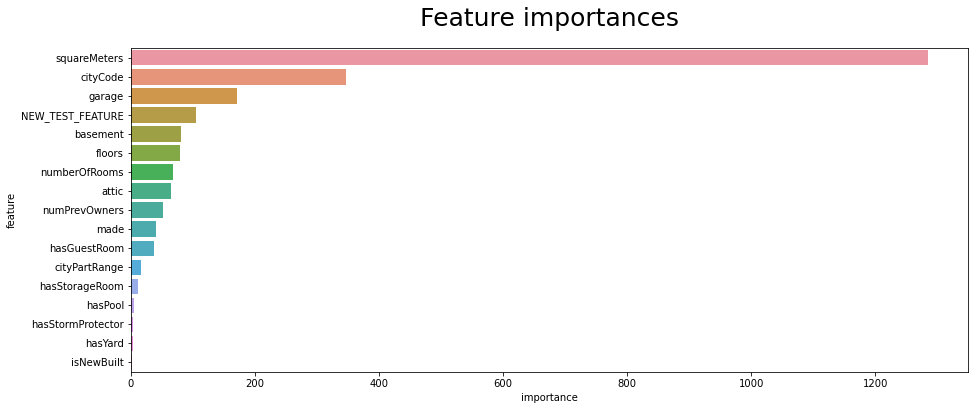

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 174153.42875877564
Fold 1 	 RMSE: 138045.66846471516
Fold 2 	 RMSE: 36344.2776505199
Fold 3 	 RMSE: 190961.9844714435
Fold 4 	 RMSE: 64663.11304995056
Fold 5 	 RMSE: 281772.62215587235
Fold 6 	 RMSE: 199747.71077761773
Fold 7 	 RMSE: 93988.13051612231
AVG RMSE: 147459.61698062715


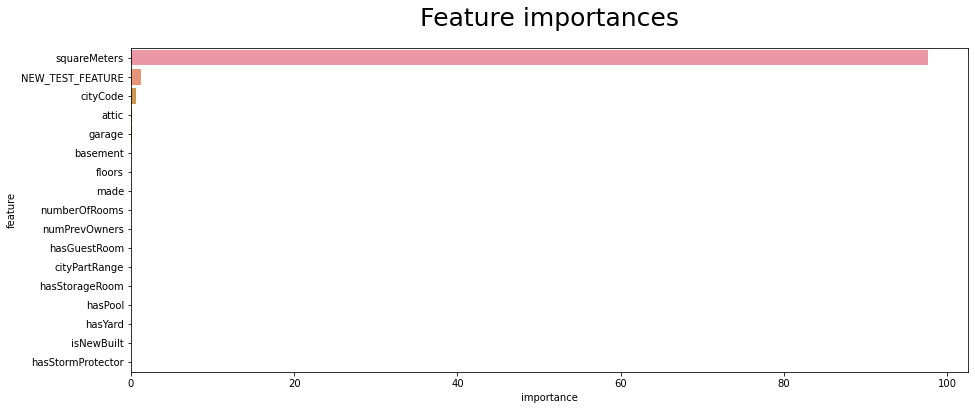

In [23]:
# featIdea #4
for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.attic / dataset.squareMeters

test_it(all_datasets)

## Result: MOST Important so far!!

# FeatIdea #5: Basement/squareMeters: Basement size to total house size ratio

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 154629.6243391637
Fold 1 	 RMSE: 128092.23765608075
Fold 2 	 RMSE: 76578.55398314058
Fold 3 	 RMSE: 165738.5400713811
Fold 4 	 RMSE: 75331.40611278564
Fold 5 	 RMSE: 284900.75243549154
Fold 6 	 RMSE: 176487.00870407905
Fold 7 	 RMSE: 76920.12756708066
AVG RMSE: 142334.78135865036


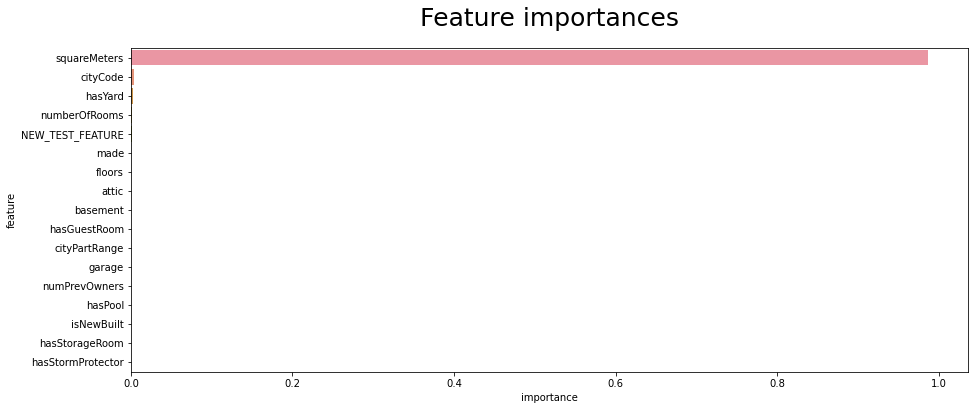

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171048.844195298
Fold 1 	 RMSE: 154124.17465457303
Fold 2 	 RMSE: 59979.777930494485
Fold 3 	 RMSE: 202279.69143663926
Fold 4 	 RMSE: 61308.10346696122
Fold 5 	 RMSE: 286536.9916272191
Fold 6 	 RMSE: 210569.86791048208
Fold 7 	 RMSE: 88016.81613505703
AVG RMSE: 154233.03341959053


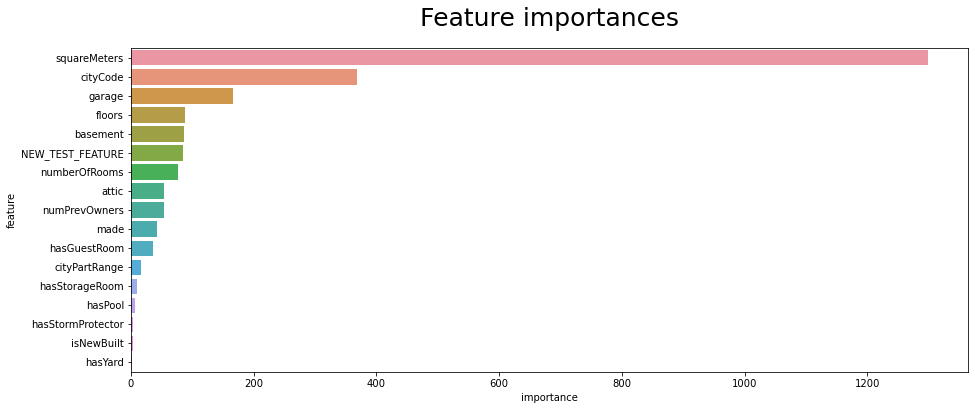

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 165743.83678103937
Fold 1 	 RMSE: 146857.16351962512
Fold 2 	 RMSE: 42184.388103632846
Fold 3 	 RMSE: 187909.7595389999
Fold 4 	 RMSE: 66414.91508988451
Fold 5 	 RMSE: 279309.52807204635
Fold 6 	 RMSE: 206155.85654230398
Fold 7 	 RMSE: 85316.29180656138
AVG RMSE: 147486.46743176167


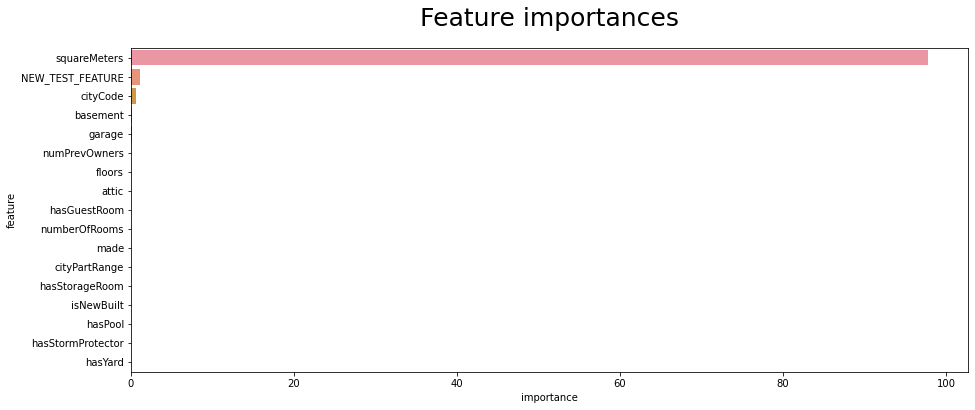

In [24]:
for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.basement / dataset.squareMeters

test_it(all_datasets)

## Result: Definitely Important!

# FeatIdea #6. Garage/squareMeters: Garage size to total house size ratio

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 160353.19047271332
Fold 1 	 RMSE: 128776.78591461046
Fold 2 	 RMSE: 66130.09942822738
Fold 3 	 RMSE: 164589.43808815553
Fold 4 	 RMSE: 75182.55701028163
Fold 5 	 RMSE: 284520.0633245491
Fold 6 	 RMSE: 176895.39266615183
Fold 7 	 RMSE: 71839.50502962005
AVG RMSE: 141035.87899178866


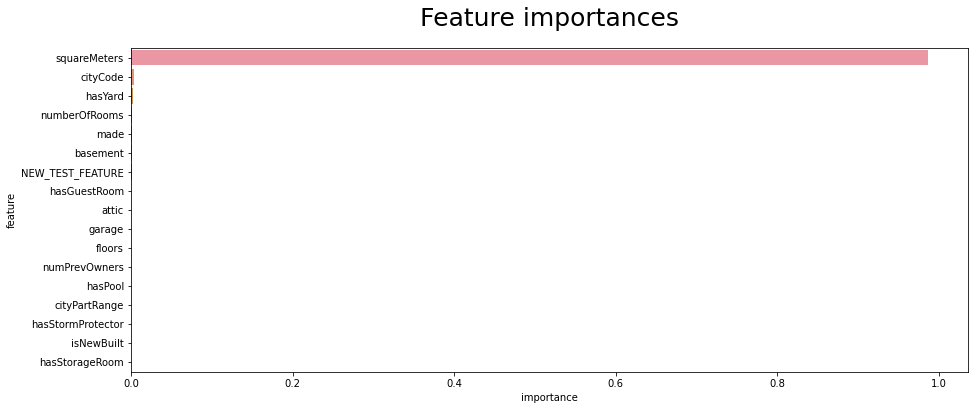

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171353.8276170062
Fold 1 	 RMSE: 153219.97416400193
Fold 2 	 RMSE: 59074.16827642382
Fold 3 	 RMSE: 200521.40514280318
Fold 4 	 RMSE: 61331.45432203179
Fold 5 	 RMSE: 284686.16267423396
Fold 6 	 RMSE: 209054.04583203827
Fold 7 	 RMSE: 89914.54619449037
AVG RMSE: 153644.4480278787


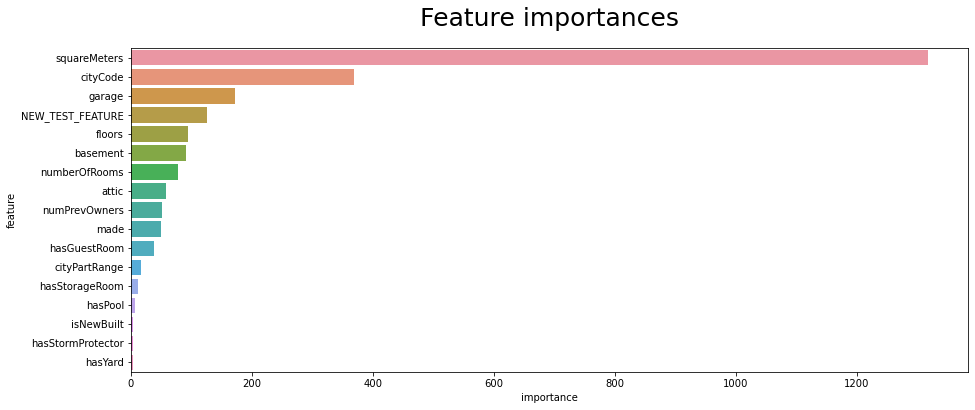

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 172619.7607174057
Fold 1 	 RMSE: 147843.16223678822
Fold 2 	 RMSE: 37698.6753717229
Fold 3 	 RMSE: 191991.1877659346
Fold 4 	 RMSE: 65053.12876549982
Fold 5 	 RMSE: 273236.79608064116
Fold 6 	 RMSE: 185777.35328215256
Fold 7 	 RMSE: 82263.41093296472
AVG RMSE: 144560.4343941387


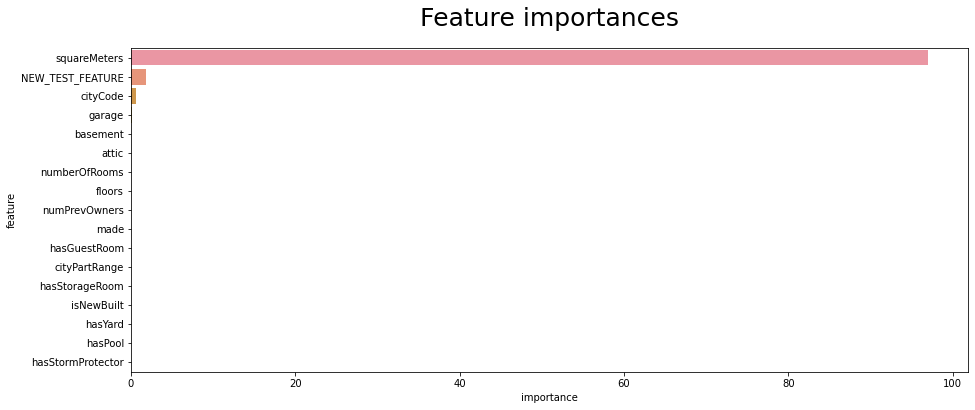

In [25]:
for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.garage / dataset.squareMeters

test_it(all_datasets)

## Result: Another important feature!

# FeatIdea #7: Grouping zip codes

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 154188.27278516119
Fold 1 	 RMSE: 127635.99800495614
Fold 2 	 RMSE: 66390.78593262316
Fold 3 	 RMSE: 168424.67336041204
Fold 4 	 RMSE: 73247.73085932412
Fold 5 	 RMSE: 284545.5162397819
Fold 6 	 RMSE: 177638.5351377841
Fold 7 	 RMSE: 63436.759232980054
AVG RMSE: 139438.53394412785


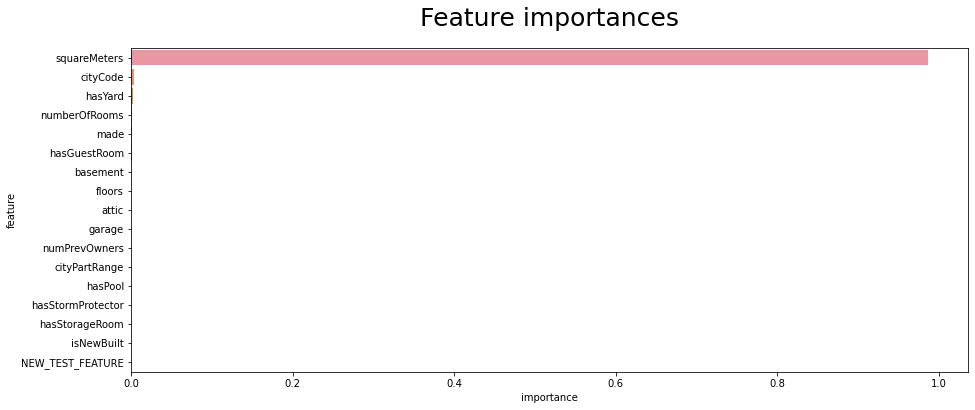

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 170972.11663922507
Fold 1 	 RMSE: 145878.76660909582
Fold 2 	 RMSE: 40233.28898626729
Fold 3 	 RMSE: 199379.42164727766
Fold 4 	 RMSE: 61868.38533577803
Fold 5 	 RMSE: 282110.6405795124
Fold 6 	 RMSE: 210763.30645056476
Fold 7 	 RMSE: 78382.57029528897
AVG RMSE: 148698.56206787628


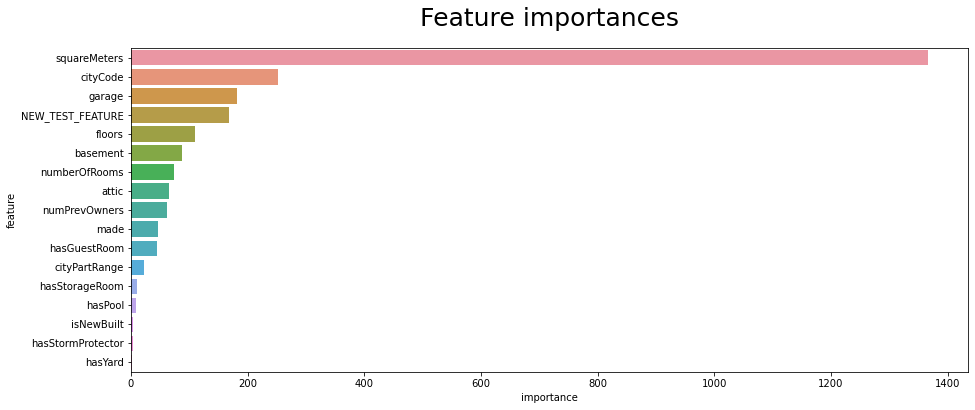

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 172337.2625377865
Fold 1 	 RMSE: 131791.7588028629
Fold 2 	 RMSE: 35617.75426534958
Fold 3 	 RMSE: 185690.93976157968
Fold 4 	 RMSE: 64189.19339744784
Fold 5 	 RMSE: 279938.8532435349
Fold 6 	 RMSE: 198486.99403908398
Fold 7 	 RMSE: 79453.98543628804
AVG RMSE: 143438.34268549166


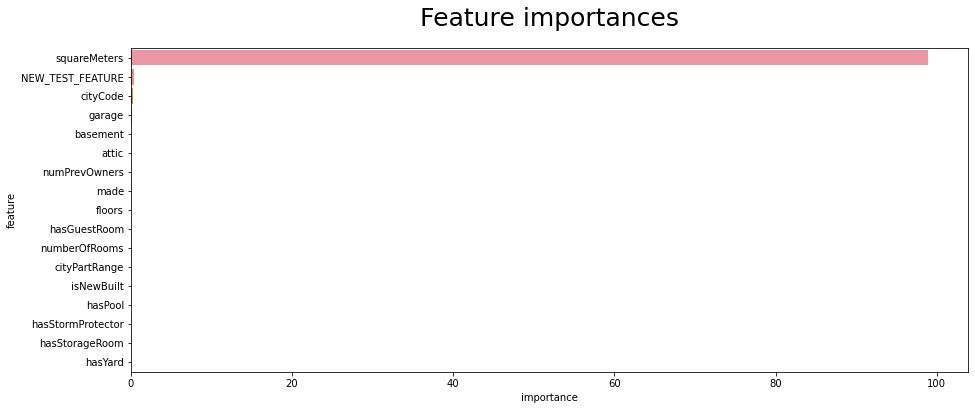

In [52]:
# new_datasets = dict(map(lambda x: (x[0], x[1].copy()), all_datasets.items()))

for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.cityCode // 100
#     dataset.drop(columns="cityCode", inplace=True)

test_it(all_datasets)

# FeatIdea #8: Add avg price per block as a feature.
Make a block by diving cityCode by 100

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 156938.16072076964
Fold 1 	 RMSE: 128447.80452050644
Fold 2 	 RMSE: 77517.78058921263
Fold 3 	 RMSE: 164570.6450464235
Fold 4 	 RMSE: 74783.28990894392
Fold 5 	 RMSE: 283114.57127927814
Fold 6 	 RMSE: 178363.31907450774
Fold 7 	 RMSE: 91947.92658897884
AVG RMSE: 144460.4372160776


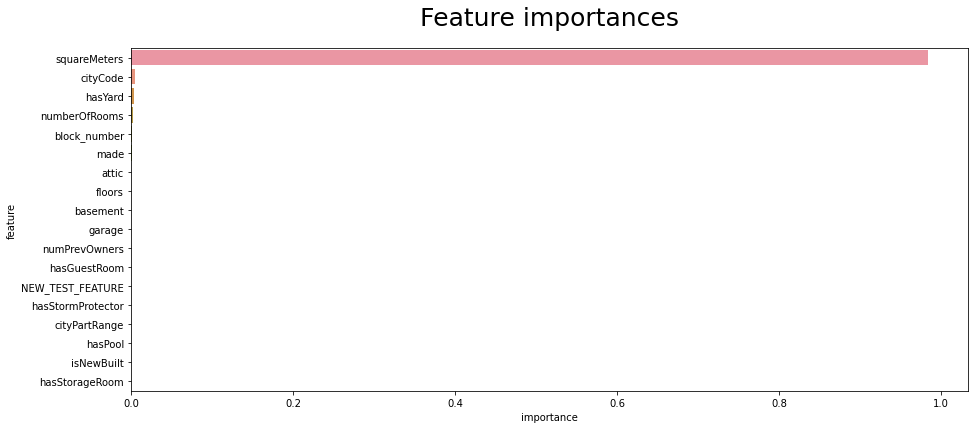

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 172314.7176849526
Fold 1 	 RMSE: 151203.65763254487
Fold 2 	 RMSE: 48528.422425633566
Fold 3 	 RMSE: 199567.1530086567
Fold 4 	 RMSE: 64097.25731941321
Fold 5 	 RMSE: 285598.3814898482
Fold 6 	 RMSE: 205846.8200420518
Fold 7 	 RMSE: 86332.99068368122
AVG RMSE: 151686.17503584776


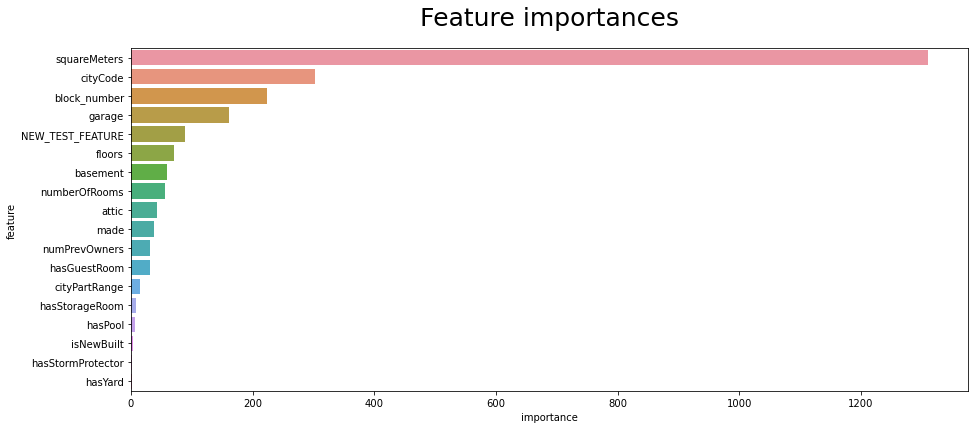

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 172341.4960226977
Fold 1 	 RMSE: 136285.8410778254
Fold 2 	 RMSE: 40294.99353674264
Fold 3 	 RMSE: 176778.87883872094
Fold 4 	 RMSE: 67425.55090638467
Fold 5 	 RMSE: 280609.1173765322
Fold 6 	 RMSE: 188672.93220359326
Fold 7 	 RMSE: 68340.44457403073
AVG RMSE: 141343.65681706593


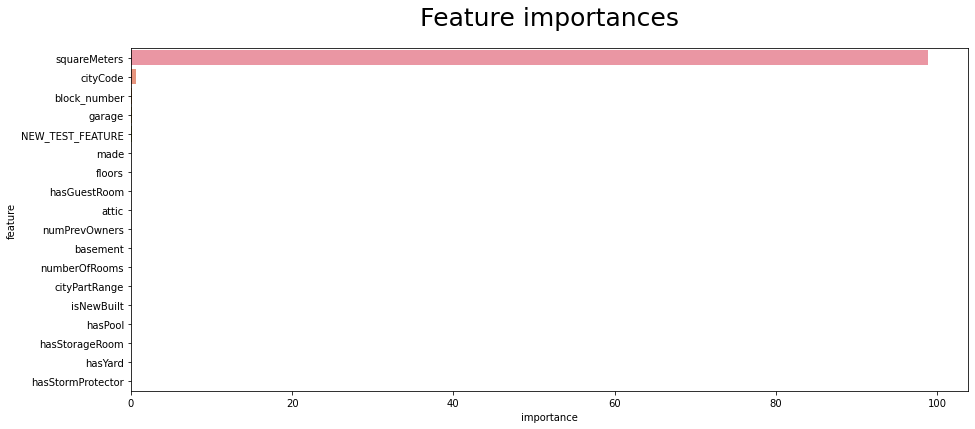

In [68]:
train_new = all_datasets["train"]
train_new["block_number"] = dataset.cityCode // 100
# lets find the blocks which have the highest avg house price
avg_house_cost_per_block = train_new.groupby("block_number")["price"].mean().to_dict()
# print(avg_house_cost_per_block.to_dict())

for _, dataset in all_datasets.items():
    dataset["NEW_TEST_FEATURE"] = dataset.cityCode // 100
    dataset["NEW_TEST_FEATURE"] = dataset.NEW_TEST_FEATURE.map(avg_house_cost_per_block)

#     dataset.drop(columns="cityCode", inplace=True)

test_it(all_datasets)

## Result: Definitely Important